In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rosbag
# import pymap3d as pm

from scipy.signal import savgol_filter
%matplotlib inline

def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def to_euler(x, y, z, w):
    """Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])

In [42]:
bagfilename = '2021-02-13-11-35-54'
bag = rosbag.Bag(bagfilename + '.bag')
# print(bag)

In [43]:
t = []
steer_front = []
throttle = []
brake = []
locker = []
e_lat = []
e_yaw = []
autonomous_mode = []

for topic, msg, _ in bag.read_messages(topics=['/control_signal']):
    t.append(msg.header.stamp.to_sec())
    steer_front.append(msg.pose.covariance[0])
    throttle.append(msg.pose.covariance[1])
    brake.append(msg.pose.covariance[2])
    locker.append(msg.pose.covariance[3])
    e_lat.append(msg.pose.covariance[4])
    e_yaw.append(msg.pose.covariance[5])
    autonomous_mode.append(msg.pose.covariance[10])
    
mega_t = []
mega_pendant_mode = []
for topic, msg, _ in bag.read_messages(topics=['/logging_arduino']):
    mega_t.append(msg.header.stamp.to_sec())
    mega_pendant_mode.append(msg.pose.covariance[0])
    
est_t = []
est_x_est = []
est_y_est = []
est_v_est = []
est_yaw_est = []
est_yaw_gnss_fr = []
for topic, msg, _ in bag.read_messages(topics=['/state_estimator']):
    est_t.append(msg.header.stamp.to_sec())
    est_x_est.append(msg.x_est)
    est_y_est.append(msg.y_est)
    est_v_est.append(msg.v_est)
    est_yaw_est.append(msg.yaw_est)
    est_yaw_gnss_fr.append(msg.yaw_gnss_fr)
    
est_x_est = np.array(est_x_est)
est_y_est = np.array(est_y_est)

In [44]:
new_wp_yaw_dydx = np.arctan2((est_y_est[1:]-est_y_est[:-1]), (est_x_est[1:]-est_x_est[:-1]))

In [ ]:
new_wp_cvtr = 

(784355.2841945945, 784366.7673490376, 9239900.280382762, 9239929.682957757)

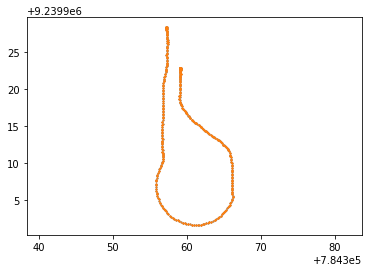

In [46]:
other_wp = np.load("2021-02-13-11-35-54.npy")
plt.scatter(other_wp[:,0], other_wp[:,1], s=1, label="other_wp")
plt.scatter(est_x_est, est_y_est, s=1, label="x_est y_est from bag")
plt.axis("equal")

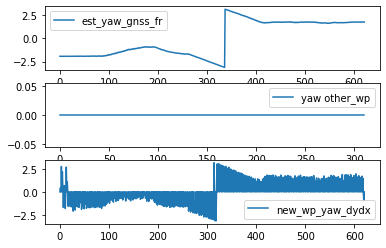

In [47]:
plt.subplot(3,1,1)
plt.plot(est_yaw_gnss_fr, label="est_yaw_gnss_fr")
plt.legend()

plt.subplot(3,1,2)
plt.plot(other_wp[:,2], label="yaw other_wp")
plt.legend()

plt.subplot(3,1,3)
plt.plot(new_wp_yaw_dydx, label="new_wp_yaw_dydx")
plt.legend()

In [50]:
new_wp = []
for i in range(len(est_x_est)):
    new_wp.append([est_x_est[i], est_y_est[i], est_yaw_gnss_fr[i], 0, 0])
new_wp = np.array(new_wp)

np.save(bagfilename+".npy", new_wp)